### Edgar Moises Hernandez-Gonzalez
#### 30/01/20-25/03/20
#### Clasificacion de imagenes motoras en EEG con CNN-2D
##### Caracteristicas = Espectrogramas STFFT (3D)
##### Concatenacion horizontal
##### 5 ejecuciones independientes

#### CNN-2D
##### Sujeto 1
##### Accuracy = 61.11%
##### Kappa = 0.4815

#### CNN-2D BN
##### Sujeto 1
##### Accuracy = 56.94%
##### Kappa = 0.4259

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from scipy.signal import spectrogram
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPool2D, Flatten, Dense, Dropout,
                                     BatchNormalization, Activation)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [ ]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [ ]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01E.csv", header=None)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(288, 22000)
(288, 22000)
(288, 1)
(288, 1)


In [ ]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 288
n_samples_test : 288


In [ ]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 4


In [ ]:
#codificar etiquetas con valores de 0 a nClases-1
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
#unir 22 canales
def unir_espectrogramas_horizontal(data):
  fs = 250
  datos = np.zeros((288,24,88))
  temporal = np.zeros((24,88))
  for i in range(data.shape[0]): #288 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      f, t, Sxx = spectrogram(sig, fs) #espectrograma de STFFT
      temporal[:, j*4:(j+1)*4] = Sxx[8:32, :]
    datos[i] = temporal
  return datos

In [ ]:
#llamar a unir_espectrogramas_horizontal(data, fs)
x_train = unir_espectrogramas_horizontal(x_train)
x_test = unir_espectrogramas_horizontal(x_test)

In [ ]:
print(x_train.shape)
print(x_test.shape)

(288, 24, 88)
(288, 24, 88)


In [ ]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))

127.36705810165053
103.14882408038861
3.3899630126531786e-07
5.741129212423684e-07


In [ ]:
#convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_train /= 128.0
x_test /= 128.0

In [ ]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))

0.99505514
0.8058502
2.6484086e-09
4.485257e-09


In [ ]:
#convertir de 3D a 4D
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

print(x_train.shape)
print(x_test.shape)

(288, 24, 88, 1)
(288, 24, 88, 1)


In [ ]:
def CNN_2D():
  model = Sequential()
  model.add(Conv2D(16, (3,3), activation='relu', padding='same',
                   input_shape=x_train.shape[1:]))
  model.add(MaxPool2D((2,2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-5)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

In [ ]:
def CNN_2D_BN():
  model = Sequential()
  model.add(Conv2D(16, (3,3), padding='same', input_shape=x_train.shape[1:]))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Flatten())
  model.add(Dense(128))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-6)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

Iteration: 1
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
288/288 - 0s - loss: 0.9555 - acc: 0.5833
kappa:  0.4444444444444444
f1: 0.584312459472413
confusion matrix:
 [[39 18  9  6]
 [23 41  8  0]
 [ 1  3 46 22]
 [ 2  0 28 42]]


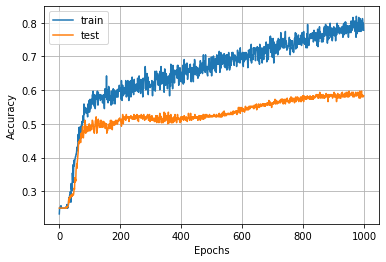

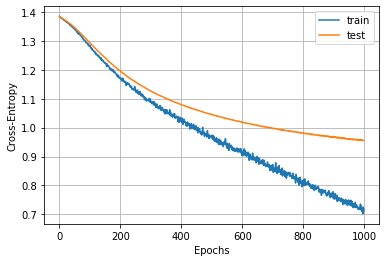

Iteration: 2
288/288 - 0s - loss: 0.9552 - acc: 0.5660
kappa:  0.4212962962962963
f1: 0.563932145285978
confusion matrix:
 [[32 25  8  7]
 [22 44  6  0]
 [ 1  4 46 21]
 [ 1  1 29 41]]


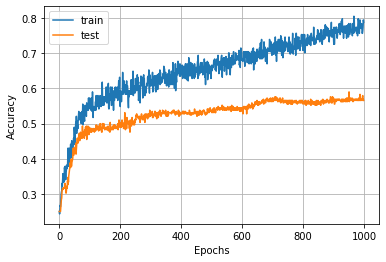

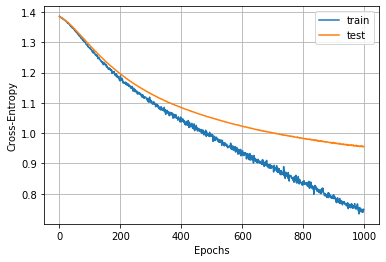

Iteration: 3
288/288 - 0s - loss: 0.9312 - acc: 0.5938
kappa:  0.45833333333333337
f1: 0.5930568302653241
confusion matrix:
 [[35 22  9  6]
 [18 47  7  0]
 [ 3  4 45 20]
 [ 1  1 26 44]]


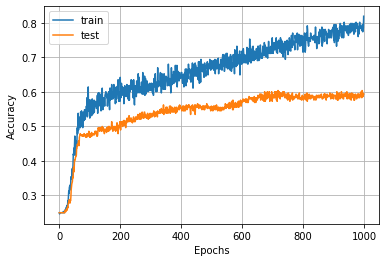

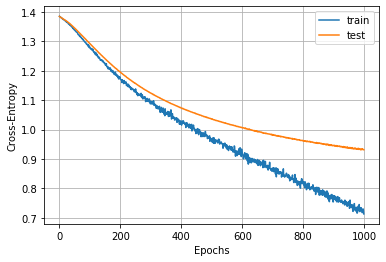

Iteration: 4
288/288 - 0s - loss: 0.9468 - acc: 0.5868
kappa:  0.44907407407407407
f1: 0.5827942685686259
confusion matrix:
 [[31 28  8  5]
 [17 49  6  0]
 [ 2  3 48 19]
 [ 2  2 27 41]]


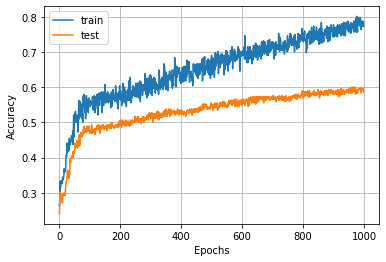

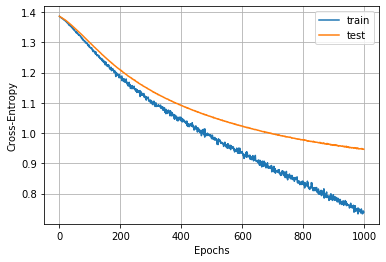

Iteration: 5
288/288 - 0s - loss: 0.9568 - acc: 0.5868
kappa:  0.44907407407407407
f1: 0.5870605836006301
confusion matrix:
 [[38 20  8  6]
 [19 47  6  0]
 [ 3  4 44 21]
 [ 3  1 28 40]]


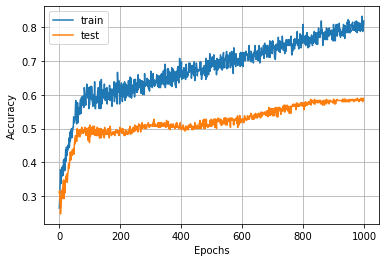

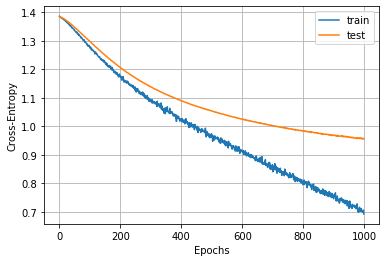


Resultados:
loss: [0.9554669327206082, 0.9552443755997552, 0.9312011069721646, 0.9467564291424222, 0.956785606013404]
accuracy: [0.5833333, 0.5659722, 0.59375, 0.5868056, 0.5868056]
kappa: [0.4444444444444444, 0.4212962962962963, 0.45833333333333337, 0.44907407407407407, 0.44907407407407407]
f1: [0.584312459472413, 0.563932145285978, 0.5930568302653241, 0.5827942685686259, 0.5870605836006301]


In [ ]:
array_loss = []
array_acc = []
array_kappa = []
for i in range(5):
  print("Iteration:", i+1)
    
  model = CNN_2D()

  history = model.fit(x_train, y_train, epochs=1000, batch_size=18,
                      validation_data=(x_test, y_test), verbose=0)
    
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
  array_loss.append(test_loss)
  array_acc.append(test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 24, 88, 16)        160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 44, 16)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 8448)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               1081472   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 516       
Total params: 1,082,148
Trainable params: 1,082,148
Non-trainable params: 0
____________________________________________

In [ ]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))

Mean Accuracy: 0.5833
std: (+/- 0.0093)
Mean Kappa: 0.4444
std: (+/- 0.0124)
Mean F1: 0.5822
Max Accuracy: 0.5938
Max Kappa: 0.4583
Max F1: 0.5931
